# Design an LSTM model to predict the next number in a sequence [1,3,5,7,9,11,13,15,17,19,21].Train the model and test it to predict the next number in the sequence. Compute the loss function and record the insights about the models perfromace. 

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Define the sequence
data = np.array([1,3,5,7,9,11,13,15,17,19,21,23,25,27,29], dtype=float)
#data = np.array([1,3,5,7,9], dtype=float)

# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data.reshape(-1, 1))

# Prepare the dataset
sequence_length = 5 # in real time 8, 128, 256. 8 16,32
X, y = [], [] # X - input 1,3,5,7,9 y = 11, 3,5,7,9,11 y = 13
for i in range(len(data) - sequence_length):
    X.append(data[i:i+sequence_length])
    y.append(data[i+sequence_length])
X, y = np.array(X), np.array(y)
#print(X,y)

# Convert to PyTorch tensors
X_train = torch.tensor(X, dtype=torch.float32) # if data is more use float.16
y_train = torch.tensor(y, dtype=torch.float32)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize and train the model
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

# Predict the next number
model.eval()
with torch.no_grad():
    test_input = torch.tensor(data[-sequence_length:].reshape(1, sequence_length, 1), dtype=torch.float32)
    predicted = model(test_input).numpy()
    predicted = scaler.inverse_transform(predicted.reshape(-1, 1))
    print(f'Predicted Next Number: {predicted[0][0]:.2f}')

# Compute performance metric (MSE)
y_train_pred = model(X_train).detach().numpy()
y_train_pred = scaler.inverse_transform(y_train_pred)
y_train_actual = scaler.inverse_transform(y_train.numpy())

mse = np.mean((y_train_actual - y_train_pred) ** 2)
print(f'Mean Squared Error: {mse:.6f}')

Epoch [10/500], Loss: 0.018833
Epoch [20/500], Loss: 0.012210
Epoch [30/500], Loss: 0.025910
Epoch [40/500], Loss: 0.011896
Epoch [50/500], Loss: 0.008322
Epoch [60/500], Loss: 0.008734
Epoch [70/500], Loss: 0.008374
Epoch [80/500], Loss: 0.007991
Epoch [90/500], Loss: 0.007784
Epoch [100/500], Loss: 0.007621
Epoch [110/500], Loss: 0.007450
Epoch [120/500], Loss: 0.007268
Epoch [130/500], Loss: 0.007074
Epoch [140/500], Loss: 0.006869
Epoch [150/500], Loss: 0.006652
Epoch [160/500], Loss: 0.006422
Epoch [170/500], Loss: 0.006175
Epoch [180/500], Loss: 0.005911
Epoch [190/500], Loss: 0.005626
Epoch [200/500], Loss: 0.005316
Epoch [210/500], Loss: 0.004975
Epoch [220/500], Loss: 0.004597
Epoch [230/500], Loss: 0.004176
Epoch [240/500], Loss: 0.003709
Epoch [250/500], Loss: 0.003199
Epoch [260/500], Loss: 0.002654
Epoch [270/500], Loss: 0.002079
Epoch [280/500], Loss: 0.001472
Epoch [290/500], Loss: 0.000855
Epoch [300/500], Loss: 0.000323
Epoch [310/500], Loss: 0.000041
Epoch [320/500], 

# Model 2

Epoch [100/1000], Loss: 0.0530
Epoch [200/1000], Loss: 0.4461
Epoch [300/1000], Loss: 0.6496
Epoch [400/1000], Loss: 0.0913
Epoch [500/1000], Loss: 0.0003
Epoch [600/1000], Loss: 0.0700
Epoch [700/1000], Loss: 0.6814
Epoch [800/1000], Loss: 0.0429
Epoch [900/1000], Loss: 0.0084
Epoch [1000/1000], Loss: 0.0027


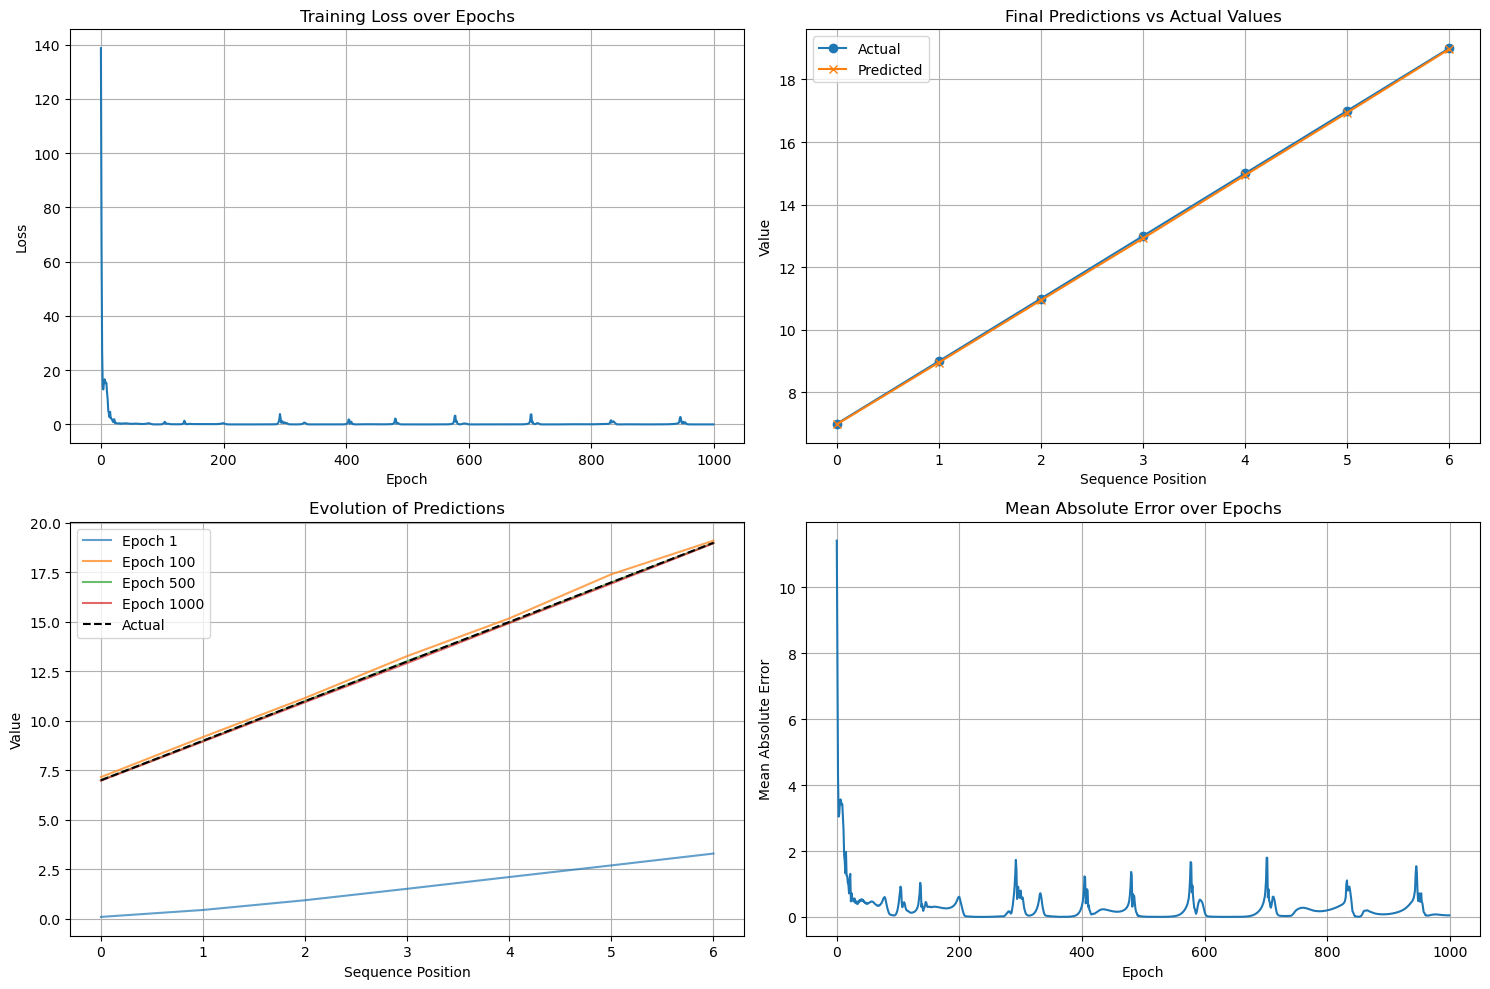


Final Results:
Last 3 numbers in sequence: [15, 17, 19]
Predicted next number: 20.08
Expected next number: 17
Final training loss: 0.002727
Final mean absolute error: 0.048890


In [3]:
# Import required libraries
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Custom Dataset class for sequence data
class SequenceDataset(Dataset):
    """
    Creates sequences of fixed length from input data for LSTM training.
    Each sequence will generate an input-target pair where target is the next number.
    """
    def __init__(self, sequence, sequence_length=3):
        # Convert input sequence to PyTorch tensor
        self.sequence = torch.FloatTensor(sequence)
        self.sequence_length = sequence_length
        
    def __len__(self):
        # Return number of possible sequences
        # Length is reduced by sequence_length as we need that many numbers for each input
        return len(self.sequence) - self.sequence_length
        
    def __getitem__(self, idx):
        # Return a tuple of (input_sequence, target)
        # Input sequence: sequence_length numbers starting at idx
        # Target: the number that follows the input sequence
        return (self.sequence[idx:idx+self.sequence_length],
                self.sequence[idx+self.sequence_length])

# LSTM Model Definition
class SequenceLSTM(nn.Module):
    """
    LSTM neural network for sequence prediction.
    Architecture: LSTM layer followed by a linear layer to produce final prediction.
    """
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(SequenceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer with specified parameters
        # batch_first=True means input shape is (batch, sequence, feature)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Linear layer to transform LSTM output to prediction
        self.linear = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        # Shape: (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        
        # Forward propagate LSTM
        # x shape: (batch_size, sequence_length) -> (batch_size, sequence_length, 1)
        # out shape: (batch_size, sequence_length, hidden_size)
        out, (hn, cn) = self.lstm(x.unsqueeze(-1), (h0, c0))
        
        # Decode the hidden state of the last time step
        # out[:, -1, :] takes the last time step output
        out = self.linear(out[:, -1, :])
        return out

# Prepare training data
sequence = [1, 3, 5, 7, 9,11,13,15,17,19]  # Arithmetic sequence with difference of 2
dataset = SequenceDataset(sequence, sequence_length=3)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Initialize model components
model = SequenceLSTM()  # Create LSTM model instance
criterion = nn.MSELoss()  # Mean Squared Error loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer

# Lists to store metrics for visualization
epoch_losses = []  # Store average loss for each epoch
predictions_over_time = []  # Store predictions at each epoch
actual_values = []  # Store actual target values

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0
    epoch_predictions = []
    
    # Iterate over all sequences in the dataset
    for X, y in dataloader:
        # Reset gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(X)
        
        # Calculate loss
        loss = criterion(output, y.unsqueeze(1))
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Store metrics
        total_loss += loss.item()
        epoch_predictions.append(output.detach().numpy())
        
        # Store actual values only once (they don't change)
        if epoch == 0:
            actual_values.append(y.item())
    
    # Calculate and store average loss for this epoch
    avg_loss = total_loss/len(dataloader)
    epoch_losses.append(avg_loss)
    predictions_over_time.append([pred[0][0] for pred in epoch_predictions])
    
    # Print progress every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Test the model
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    # Predict the next number using the last 3 numbers
    test_sequence = torch.FloatTensor(sequence[-3:])
    prediction = model(test_sequence.unsqueeze(0))
    predicted_number = prediction.item()

# Visualization Section
plt.figure(figsize=(15, 10))

# Plot 1: Training Loss
plt.subplot(2, 2, 1)
plt.plot(epoch_losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot 2: Final Predictions vs Actual Values
plt.subplot(2, 2, 2)
plt.plot(actual_values, label='Actual', marker='o')
plt.plot(predictions_over_time[-1], label='Predicted', marker='x')
plt.title('Final Predictions vs Actual Values')
plt.xlabel('Sequence Position')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Plot 3: Evolution of Predictions
plt.subplot(2, 2, 3)
epochs_to_plot = [0, 99, 499, 999]  # Select epochs to visualize
for epoch_idx in epochs_to_plot:
    plt.plot(predictions_over_time[epoch_idx], 
             label=f'Epoch {epoch_idx + 1}',
             alpha=0.7)
plt.plot(actual_values, label='Actual', linestyle='--', color='black')
plt.title('Evolution of Predictions')
plt.xlabel('Sequence Position')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Plot 4: Mean Absolute Error Over Time
plt.subplot(2, 2, 4)
# Calculate mean absolute error for each epoch
errors_over_time = [np.mean(np.abs(np.array(pred) - np.array(actual_values))) 
                    for pred in predictions_over_time]
plt.plot(errors_over_time)
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.grid(True)

# Adjust layout and display plots
plt.tight_layout()
plt.show()

# Print final results
print(f"\nFinal Results:")
print(f"Last 3 numbers in sequence: {sequence[-3:]}")
print(f"Predicted next number: {predicted_number:.2f}")
print(f"Expected next number: 17")
print(f"Final training loss: {epoch_losses[-1]:.6f}")
print(f"Final mean absolute error: {errors_over_time[-1]:.6f}")

# Code 3


=== Data Preparation ===
Original sequence: [1, 3, 5, 7, 9, 11, 13, 15]

=== SequenceDataset Initialization ===
Input sequence: [1, 3, 5, 7, 9, 11, 13, 15]
Converted to tensor: tensor([ 1.,  3.,  5.,  7.,  9., 11., 13., 15.])
Sequence length for input: 3
Number of possible sequences: 5
DataLoader created with 5 batches

=== LSTM Model Initialization ===
Input size: 1
Hidden size: 50
Number of layers: 1

Model structure:
LSTM layer: LSTM(1, 50, batch_first=True)
Linear layer: Linear(in_features=50, out_features=1, bias=True)

=== Starting Training for 1000 epochs ===

=== Training Epoch 1 ===

--- Getting sequence 0 ---
Input sequence: tensor([1., 3., 5.])
Target value: 7.0

Batch 1:
Input sequence: [1. 3. 5.]
Target value: 7.0

--- Forward Pass ---
Input shape: torch.Size([1, 3])
Initial hidden state shape: torch.Size([1, 1, 50])
Initial cell state shape: torch.Size([1, 1, 50])
Reshaped input shape: torch.Size([1, 3, 1])
LSTM output shape: torch.Size([1, 3, 50])
Final hidden state sha

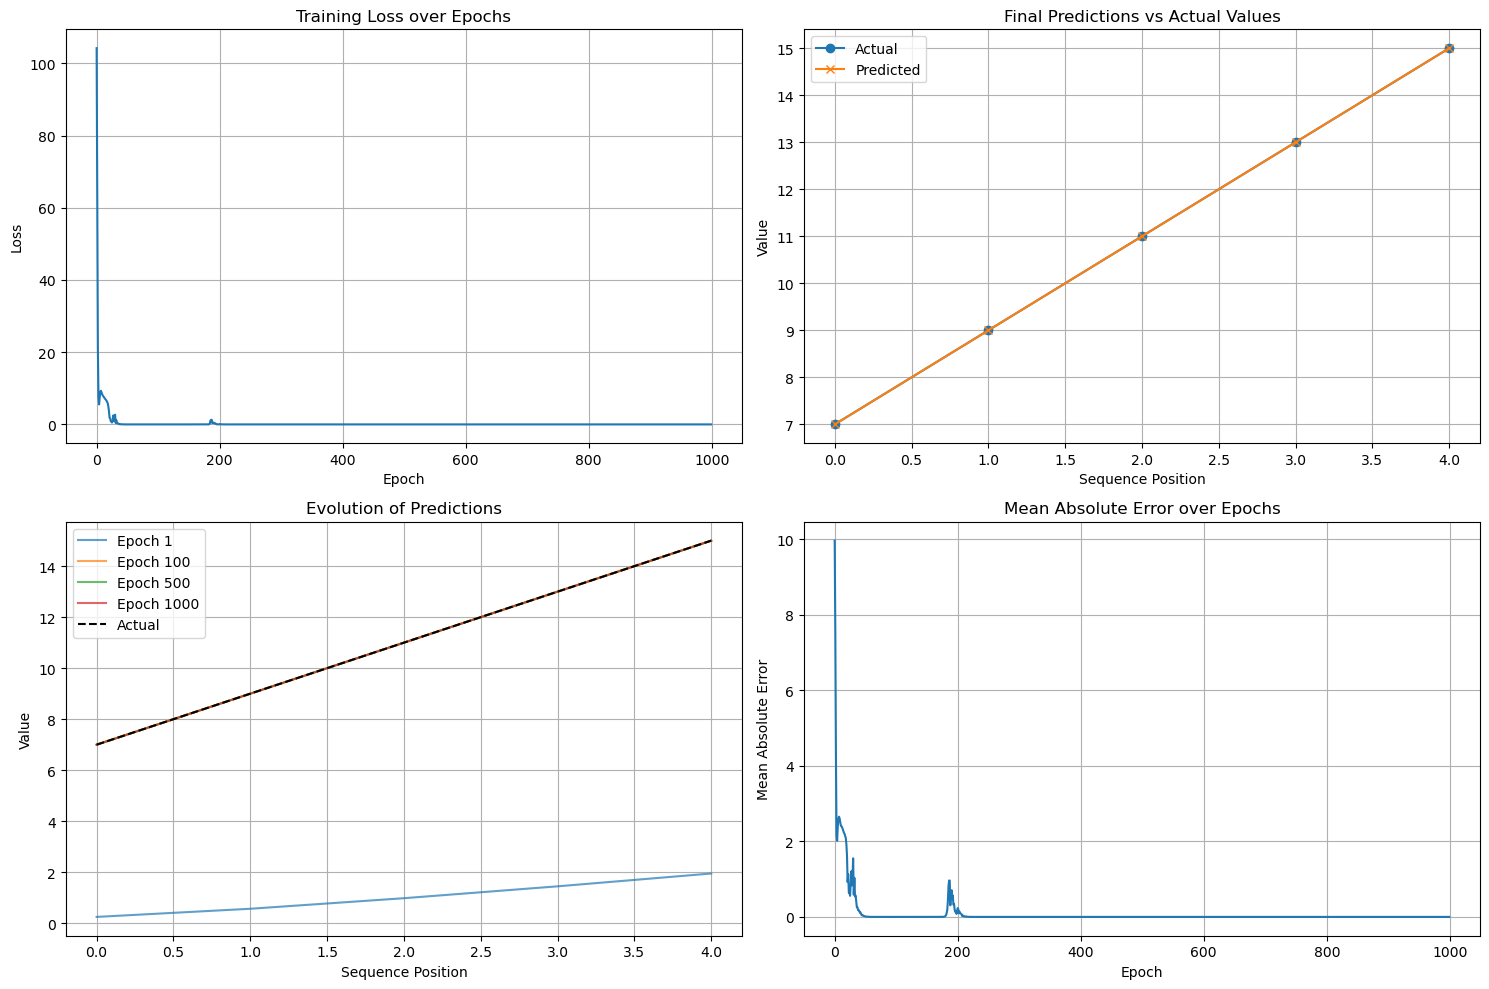


=== Final Results ===
Last 3 numbers in sequence: [11, 13, 15]
Predicted next number: 15.2870
Expected next number: 17
Final training loss: 0.000000
Final mean absolute error: 0.000000


In [3]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

class SequenceDataset(Dataset):
    def __init__(self, sequence, sequence_length=3):
        print("\n=== SequenceDataset Initialization ===")
        print(f"Input sequence: {sequence}")
        self.sequence = torch.FloatTensor(sequence)
        print(f"Converted to tensor: {self.sequence}")
        self.sequence_length = sequence_length
        print(f"Sequence length for input: {sequence_length}")
        print(f"Number of possible sequences: {len(self)}")
        
    def __len__(self):
        return len(self.sequence) - self.sequence_length
        
    def __getitem__(self, idx):
        input_seq = self.sequence[idx:idx+self.sequence_length]
        target = self.sequence[idx+self.sequence_length]
        print(f"\n--- Getting sequence {idx} ---")
        print(f"Input sequence: {input_seq}")
        print(f"Target value: {target}")
        return (input_seq, target)

class SequenceLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(SequenceLSTM, self).__init__()
        print("\n=== LSTM Model Initialization ===")
        print(f"Input size: {input_size}")
        print(f"Hidden size: {hidden_size}")
        print(f"Number of layers: {num_layers}")
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
        # Print model structure
        print("\nModel structure:")
        print(f"LSTM layer: {self.lstm}")
        print(f"Linear layer: {self.linear}")
    
    def forward(self, x):
        print("\n--- Forward Pass ---")
        print(f"Input shape: {x.shape}")
        
        # Initialize hidden states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        print(f"Initial hidden state shape: {h0.shape}")
        print(f"Initial cell state shape: {c0.shape}")
        
        # Reshape input for LSTM
        x_reshaped = x.unsqueeze(-1)
        print(f"Reshaped input shape: {x_reshaped.shape}")
        
        # LSTM forward pass
        out, (hn, cn) = self.lstm(x_reshaped, (h0, c0))
        print(f"LSTM output shape: {out.shape}")
        print(f"Final hidden state shape: {hn.shape}")
        
        # Linear layer
        final_out = self.linear(out[:, -1, :])
        print(f"Final output shape: {final_out.shape}")
        print(f"Predicted value: {final_out.item():.4f}")
        
        return final_out

def train_epoch(model, dataloader, criterion, optimizer, epoch_num):
    print(f"\n=== Training Epoch {epoch_num + 1} ===")
    total_loss = 0
    epoch_predictions = []
    
    for batch_idx, (X, y) in enumerate(dataloader):
        print(f"\nBatch {batch_idx + 1}:")
        print(f"Input sequence: {X.numpy().flatten()}")
        print(f"Target value: {y.item()}")
        
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y.unsqueeze(1))
        
        print(f"Predicted value: {output.item():.4f}")
        print(f"Batch loss: {loss.item():.6f}")
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        epoch_predictions.append(output.detach().numpy())
    
    avg_loss = total_loss/len(dataloader)
    print(f"\nEpoch {epoch_num + 1} - Average loss: {avg_loss:.6f}")
    return avg_loss, epoch_predictions

# Prepare data
print("\n=== Data Preparation ===")
sequence = [1, 3, 5, 7, 9, 11, 13, 15]
print(f"Original sequence: {sequence}")

dataset = SequenceDataset(sequence, sequence_length=3)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
print(f"DataLoader created with {len(dataloader)} batches")

# Initialize model and training components
model = SequenceLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Lists for storing metrics
epoch_losses = []
predictions_over_time = []
actual_values = []

# Training loop
num_epochs = 1000
print(f"\n=== Starting Training for {num_epochs} epochs ===")

for epoch in range(num_epochs):
    model.train()
    avg_loss, epoch_predictions = train_epoch(model, dataloader, criterion, optimizer, epoch)
    
    epoch_losses.append(avg_loss)
    predictions_over_time.append([pred[0][0] for pred in epoch_predictions])
    
    if epoch == 0:
        actual_values = [y.item() for _, y in dataloader]
    
    if (epoch + 1) % 100 == 0:
        print(f'\nEpoch [{epoch+1}/{num_epochs}]')
        print(f'Average Loss: {avg_loss:.6f}')
        print(f'Current predictions: {[f"{pred:.2f}" for pred in predictions_over_time[-1]]}')

# Testing
print("\n=== Model Testing ===")
model.eval()
with torch.no_grad():
    test_sequence = torch.FloatTensor(sequence[-3:])
    print(f"Test sequence: {test_sequence.numpy()}")
    prediction = model(test_sequence.unsqueeze(0))
    predicted_number = prediction.item()
    print(f"Final prediction: {predicted_number:.4f}")

# Visualization (same as before)
plt.figure(figsize=(15, 10))

# Plot 1: Training Loss
plt.subplot(2, 2, 1)
plt.plot(epoch_losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot 2: Final Predictions vs Actual Values
plt.subplot(2, 2, 2)
plt.plot(actual_values, label='Actual', marker='o')
plt.plot(predictions_over_time[-1], label='Predicted', marker='x')
plt.title('Final Predictions vs Actual Values')
plt.xlabel('Sequence Position')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Plot 3: Evolution of Predictions
plt.subplot(2, 2, 3)
epochs_to_plot = [0, 99, 499, 999]
for epoch_idx in epochs_to_plot:
    plt.plot(predictions_over_time[epoch_idx], 
             label=f'Epoch {epoch_idx + 1}',
             alpha=0.7)
plt.plot(actual_values, label='Actual', linestyle='--', color='black')
plt.title('Evolution of Predictions')
plt.xlabel('Sequence Position')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Plot 4: Mean Absolute Error Over Time
plt.subplot(2, 2, 4)
errors_over_time = [np.mean(np.abs(np.array(pred) - np.array(actual_values))) 
                    for pred in predictions_over_time]
plt.plot(errors_over_time)
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.grid(True)

plt.tight_layout()
plt.show()

# Final results
print("\n=== Final Results ===")
print(f"Last 3 numbers in sequence: {sequence[-3:]}")
print(f"Predicted next number: {predicted_number:.4f}")
print(f"Expected next number: 17")
print(f"Final training loss: {epoch_losses[-1]:.6f}")
print(f"Final mean absolute error: {errors_over_time[-1]:.6f}")

# Do the same process with an RNN model and compare the outputs and process with an LSTM model


=== SequenceDataset Initialization ===
Input sequence: [1, 3, 5, 7, 9, 11, 13, 15]
Converted to tensor: tensor([ 1.,  3.,  5.,  7.,  9., 11., 13., 15.])
Sequence length for input: 3

=== RNN Model Initialization ===
Input size: 1
Hidden size: 50
Number of layers: 1

RNN Model structure:
RNN layer: RNN(1, 50, batch_first=True)
Linear layer: Linear(in_features=50, out_features=1, bias=True)

=== LSTM Model Initialization ===
Input size: 1
Hidden size: 50
Number of layers: 1

LSTM Model structure:
LSTM layer: LSTM(1, 50, batch_first=True)
Linear layer: Linear(in_features=50, out_features=1, bias=True)

=== Starting RNN Training ===

--- RNN Forward Pass ---
Input shape: torch.Size([1, 3])
Initial hidden state shape: torch.Size([1, 1, 50])
Reshaped input shape: torch.Size([1, 3, 1])
RNN output shape: torch.Size([1, 3, 50])
Final output shape: torch.Size([1, 1])
Predicted value: 0.7420

--- RNN Forward Pass ---
Input shape: torch.Size([1, 3])
Initial hidden state shape: torch.Size([1, 1, 5

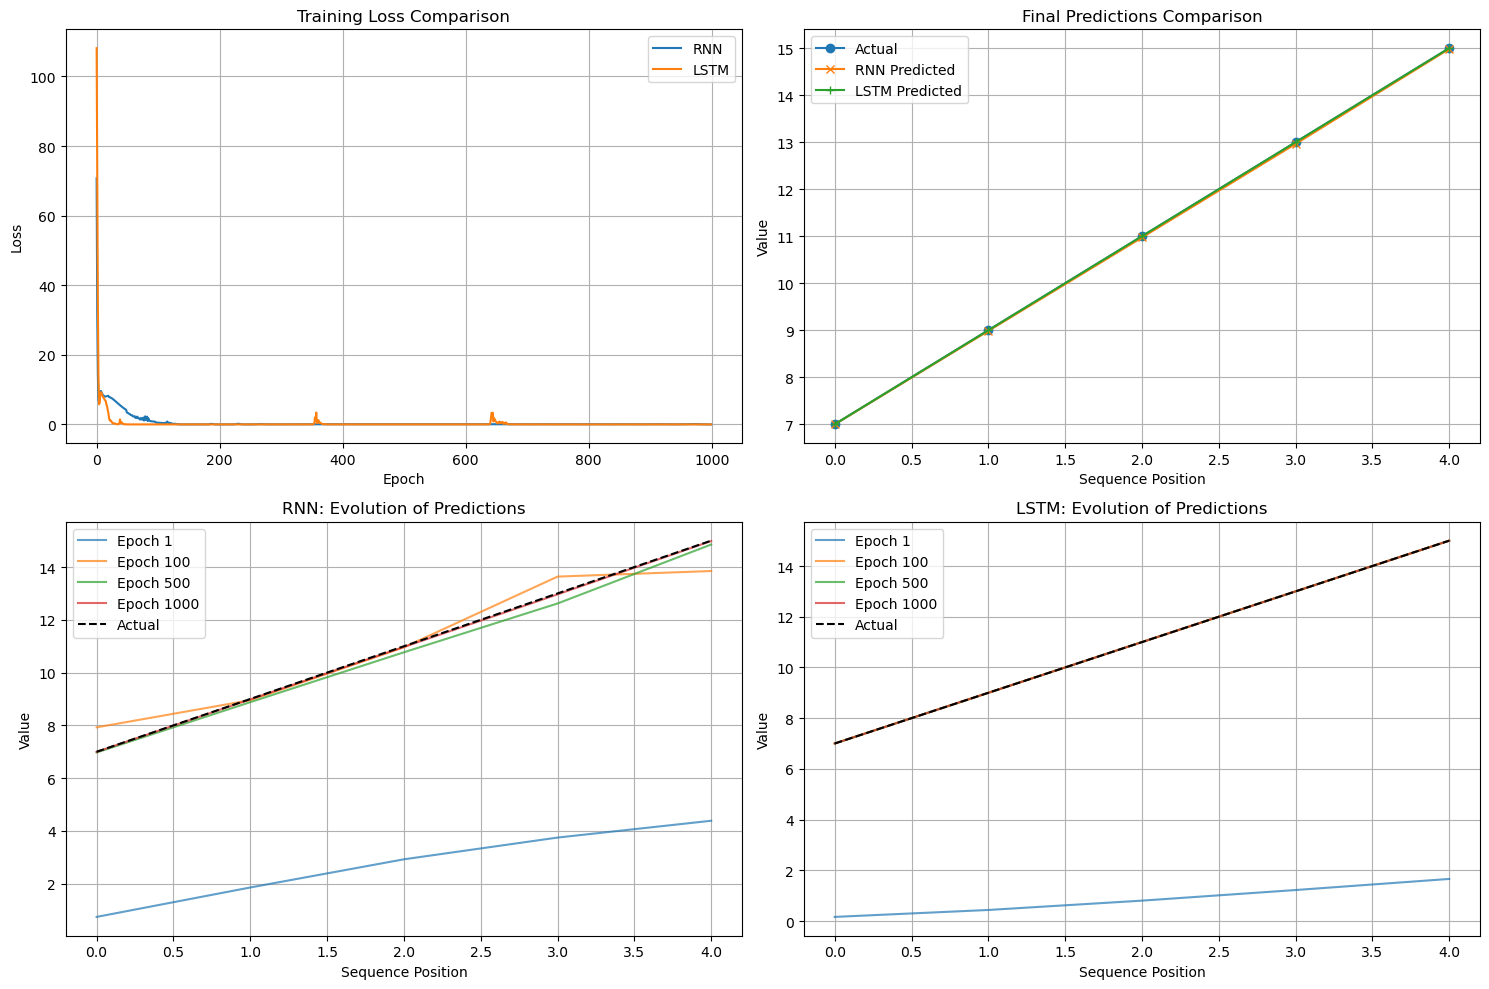


=== Final Comparison Results ===
Last 3 numbers in sequence: [11, 13, 15]
Expected next number: 17

RNN Results:
Predicted next number: 15.2841
Final training loss: 0.000496
Mean absolute error: 0.019063

LSTM Results:
Predicted next number: 15.9479
Final training loss: 0.000000
Mean absolute error: 0.000000

=== Key Differences ===
1. Model Architecture:
   RNN: Simple recurrent connections
   LSTM: Complex gates (input, forget, output) and cell state

2. Memory Handling:
   RNN: Single hidden state
   LSTM: Hidden state and cell state

3. Training Stability:
   RNN: More susceptible to vanishing gradients
   LSTM: Better at handling long-term dependencies

4. Prediction Accuracy:
   RNN error from true value: 1.7159
   LSTM error from true value: 1.0521


In [4]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

class SequenceDataset(Dataset):
    def __init__(self, sequence, sequence_length=3):
        print("\n=== SequenceDataset Initialization ===")
        print(f"Input sequence: {sequence}")
        self.sequence = torch.FloatTensor(sequence)
        print(f"Converted to tensor: {self.sequence}")
        self.sequence_length = sequence_length
        print(f"Sequence length for input: {sequence_length}")
        
    def __len__(self):
        return len(self.sequence) - self.sequence_length
        
    def __getitem__(self, idx):
        input_seq = self.sequence[idx:idx+self.sequence_length]
        target = self.sequence[idx+self.sequence_length]
        return (input_seq, target)

class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(SimpleRNN, self).__init__()
        print("\n=== RNN Model Initialization ===")
        print(f"Input size: {input_size}")
        print(f"Hidden size: {hidden_size}")
        print(f"Number of layers: {num_layers}")
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
        print("\nRNN Model structure:")
        print(f"RNN layer: {self.rnn}")
        print(f"Linear layer: {self.linear}")
    
    def forward(self, x):
        print("\n--- RNN Forward Pass ---")
        print(f"Input shape: {x.shape}")
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        print(f"Initial hidden state shape: {h0.shape}")
        
        x_reshaped = x.unsqueeze(-1)
        print(f"Reshaped input shape: {x_reshaped.shape}")
        
        out, hn = self.rnn(x_reshaped, h0)
        print(f"RNN output shape: {out.shape}")
        
        final_out = self.linear(out[:, -1, :])
        print(f"Final output shape: {final_out.shape}")
        print(f"Predicted value: {final_out.item():.4f}")
        
        return final_out

class SequenceLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(SequenceLSTM, self).__init__()
        print("\n=== LSTM Model Initialization ===")
        print(f"Input size: {input_size}")
        print(f"Hidden size: {hidden_size}")
        print(f"Number of layers: {num_layers}")
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
        print("\nLSTM Model structure:")
        print(f"LSTM layer: {self.lstm}")
        print(f"Linear layer: {self.linear}")
    
    def forward(self, x):
        print("\n--- LSTM Forward Pass ---")
        print(f"Input shape: {x.shape}")
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        print(f"Initial hidden state shape: {h0.shape}")
        print(f"Initial cell state shape: {c0.shape}")
        
        x_reshaped = x.unsqueeze(-1)
        print(f"Reshaped input shape: {x_reshaped.shape}")
        
        out, (hn, cn) = self.lstm(x_reshaped, (h0, c0))
        print(f"LSTM output shape: {out.shape}")
        
        final_out = self.linear(out[:, -1, :])
        print(f"Final output shape: {final_out.shape}")
        print(f"Predicted value: {final_out.item():.4f}")
        
        return final_out

def train_model(model, dataloader, criterion, optimizer, num_epochs, model_name):
    print(f"\n=== Starting {model_name} Training ===")
    epoch_losses = []
    predictions_over_time = []
    actual_values = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        epoch_predictions = []
        
        for X, y in dataloader:
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y.unsqueeze(1))
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            epoch_predictions.append(output.detach().numpy())
            
            if epoch == 0:
                actual_values.append(y.item())
        
        avg_loss = total_loss/len(dataloader)
        epoch_losses.append(avg_loss)
        predictions_over_time.append([pred[0][0] for pred in epoch_predictions])
        
        if (epoch + 1) % 100 == 0:
            print(f'\n{model_name} - Epoch [{epoch+1}/{num_epochs}]')
            print(f'Average Loss: {avg_loss:.6f}')
            print(f'Current predictions: {[f"{pred:.2f}" for pred in predictions_over_time[-1]]}')
    
    return epoch_losses, predictions_over_time, actual_values

# Prepare data
sequence = [1, 3, 5, 7, 9, 11, 13, 15]
dataset = SequenceDataset(sequence, sequence_length=3)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Initialize models and training components
rnn_model = SimpleRNN()
lstm_model = SequenceLSTM()

criterion = nn.MSELoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.01)
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

# Train both models
num_epochs = 1000
rnn_results = train_model(rnn_model, dataloader, criterion, rnn_optimizer, num_epochs, "RNN")
lstm_results = train_model(lstm_model, dataloader, criterion, lstm_optimizer, num_epochs, "LSTM")

# Test both models
print("\n=== Model Testing ===")
test_sequence = torch.FloatTensor(sequence[-3:])
print(f"Test sequence: {test_sequence.numpy()}")

rnn_model.eval()
lstm_model.eval()
with torch.no_grad():
    rnn_prediction = rnn_model(test_sequence.unsqueeze(0)).item()
    lstm_prediction = lstm_model(test_sequence.unsqueeze(0)).item()

# Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Training Loss Comparison
plt.subplot(2, 2, 1)
plt.plot(rnn_results[0], label='RNN')
plt.plot(lstm_results[0], label='LSTM')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Final Predictions Comparison
plt.subplot(2, 2, 2)
plt.plot(rnn_results[2], label='Actual', marker='o')
plt.plot(rnn_results[1][-1], label='RNN Predicted', marker='x')
plt.plot(lstm_results[1][-1], label='LSTM Predicted', marker='+')
plt.title('Final Predictions Comparison')
plt.xlabel('Sequence Position')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Plot 3: RNN Prediction Evolution
plt.subplot(2, 2, 3)
epochs_to_plot = [0, 99, 499, 999]
for epoch_idx in epochs_to_plot:
    plt.plot(rnn_results[1][epoch_idx], 
             label=f'Epoch {epoch_idx + 1}',
             alpha=0.7)
plt.plot(rnn_results[2], label='Actual', linestyle='--', color='black')
plt.title('RNN: Evolution of Predictions')
plt.xlabel('Sequence Position')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Plot 4: LSTM Prediction Evolution
plt.subplot(2, 2, 4)
for epoch_idx in epochs_to_plot:
    plt.plot(lstm_results[1][epoch_idx], 
             label=f'Epoch {epoch_idx + 1}',
             alpha=0.7)
plt.plot(lstm_results[2], label='Actual', linestyle='--', color='black')
plt.title('LSTM: Evolution of Predictions')
plt.xlabel('Sequence Position')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final comparison results
print("\n=== Final Comparison Results ===")
print(f"Last 3 numbers in sequence: {sequence[-3:]}")
print(f"Expected next number: 17")
print(f"\nRNN Results:")
print(f"Predicted next number: {rnn_prediction:.4f}")
print(f"Final training loss: {rnn_results[0][-1]:.6f}")
print(f"Mean absolute error: {np.mean(np.abs(np.array(rnn_results[1][-1]) - np.array(rnn_results[2]))):.6f}")
print(f"\nLSTM Results:")
print(f"Predicted next number: {lstm_prediction:.4f}")
print(f"Final training loss: {lstm_results[0][-1]:.6f}")
print(f"Mean absolute error: {np.mean(np.abs(np.array(lstm_results[1][-1]) - np.array(lstm_results[2]))):.6f}")

# Print key differences
print("\n=== Key Differences ===")
print("1. Model Architecture:")
print("   RNN: Simple recurrent connections")
print("   LSTM: Complex gates (input, forget, output) and cell state")
print("\n2. Memory Handling:")
print("   RNN: Single hidden state")
print("   LSTM: Hidden state and cell state")
print("\n3. Training Stability:")
print("   RNN: More susceptible to vanishing gradients")
print("   LSTM: Better at handling long-term dependencies")
print(f"\n4. Prediction Accuracy:")
print(f"   RNN error from true value: {abs(rnn_prediction - 17):.4f}")
print(f"   LSTM error from true value: {abs(lstm_prediction - 17):.4f}")